In [1]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import datasets
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score, f1_score
import missingno as msno
import pgeocode
import xgboost as xgb
from sklearn.preprocessing import TargetEncoder, LabelEncoder
import scipy.stats as stats
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import re


In [2]:
df = pd.read_csv("cat_model_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897167 entries, 0 to 897166
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             897167 non-null  int64  
 1   MIS_Status             897167 non-null  object 
 2   City                   897167 non-null  object 
 3   State                  897167 non-null  object 
 4   Zip                    897167 non-null  int64  
 5   Bank                   897167 non-null  object 
 6   BankState              897167 non-null  object 
 7   NAICS                  897167 non-null  int64  
 8   Term                   897167 non-null  int64  
 9   NoEmp                  897167 non-null  int64  
 10  NewExist               896005 non-null  float64
 11  CreateJob              897167 non-null  int64  
 12  RetainedJob            897167 non-null  int64  
 13  FranchiseCode          897167 non-null  int64  
 14  UrbanRural             574341 non-nu

convert nan to string

In [34]:
df.isna().sum()

LoanNr_ChkDgt              0
Name                      14
City                       0
State                      0
Zip                        0
Bank                    1559
BankState               1566
NAICS                      0
ApprovalDate               0
ApprovalFY                 0
Term                       0
NoEmp                      0
NewExist                 136
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr               4528
LowDoc                     0
ChgOffDate            736465
DisbursementDate        2368
DisbursementGross          0
BalanceGross               0
MIS_Status                 0
ChgOffPrinGr               0
GrAppv                     0
SBA_Appv                   0
domaine d’activite         0
activities                 0
Franchise                  0
dtype: int64

df['NewExist'] = df['NewExist'].apply(lambda x: "NaN" if x == np.nan else x)
df['UrbanRural'] = df['UrbanRural'].apply(lambda x: str(x))
df['RevLineCr'] = df['RevLineCr'].apply(lambda x: "NaN" if x == np.nan else x)


df['NewExist'] = df['NewExist'].astype('str')
df['UrbanRural'] = df['UrbanRural'].astype('str')
df['GrAppv'] = df['GrAppv'].astype('str')
df

In [3]:
df['MIS_Status'] = df['MIS_Status'].map({"PIF": 1, 'CHGOFF': 0})
df.head()

,Unnamed: 0,MIS_Status,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,...,RevLineCr,LowDoc,GrAppv,NAICS_class_code,Industry,FranchiseCode_Encoded,RealEstate_Backed,Region,TermDays,Recession
0,0,1,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,...,N,Y,60000.0,45,Retail trade,No,No,Eastern,2520,0
1,1,1,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,...,N,Y,40000.0,72,Accommodation and food services,No,No,Eastern,1800,0
2,2,1,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,...,N,N,287000.0,62,Health care and social assistance,No,No,Eastern,5400,0
3,3,1,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,...,N,Y,35000.0,81,Other services,No,No,Eastern,1800,0
4,4,1,ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,240,14,...,N,N,229000.0,81,Other services,No,Yes,Eastern,7200,0


In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,MIS_Status,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,...,RevLineCr,LowDoc,GrAppv,NAICS_class_code,Industry,FranchiseCode_Encoded,RealEstate_Backed,Region,TermDays,Recession
0,1,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,...,N,Y,60000.0,45,Retail trade,No,No,Eastern,2520,0
1,1,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,...,N,Y,40000.0,72,Accommodation and food services,No,No,Eastern,1800,0
2,1,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,...,N,N,287000.0,62,Health care and social assistance,No,No,Eastern,5400,0
3,1,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,...,N,Y,35000.0,81,Other services,No,No,Eastern,1800,0
4,1,ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,...,N,N,229000.0,81,Other services,No,Yes,Eastern,7200,0


In [25]:
df["UrbanRural"].value_counts() 

UrbanRural
1.0    469281
nan    322826
2.0    105060
Name: count, dtype: int64

In [35]:
data = df.drop(["LoanNr_ChkDgt","ApprovalFY", "domaine d’activite","FranchiseCode", "ChgOffDate", "DisbursementDate", "DisbursementGross", "BalanceGross", "ChgOffPrinGr", "SBA_Appv", "Name", "City", "Zip", "Bank", "BankState", "NAICS", "RevLineCr", "ApprovalDate"], axis=1)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   State        899164 non-null  object 
 1   Term         899164 non-null  int64  
 2   NoEmp        899164 non-null  int64  
 3   NewExist     899028 non-null  float64
 4   CreateJob    899164 non-null  int64  
 5   RetainedJob  899164 non-null  int64  
 6   UrbanRural   899164 non-null  int64  
 7   LowDoc       899164 non-null  object 
 8   MIS_Status   899164 non-null  int64  
 9   GrAppv       899164 non-null  float64
 10  activities   899164 non-null  object 
 11  Franchise    899164 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 82.3+ MB


In [37]:
df.dtypes

LoanNr_ChkDgt           int64
Name                   object
City                   object
State                  object
Zip                     int64
Bank                   object
BankState              object
NAICS                   int64
ApprovalDate           object
ApprovalFY              int64
Term                    int64
NoEmp                   int64
NewExist              float64
CreateJob               int64
RetainedJob             int64
FranchiseCode           int64
UrbanRural              int64
RevLineCr              object
LowDoc                 object
ChgOffDate             object
DisbursementDate       object
DisbursementGross     float64
BalanceGross          float64
MIS_Status              int64
ChgOffPrinGr          float64
GrAppv                float64
SBA_Appv              float64
domaine d’activite      int64
activities             object
Franchise               int64
dtype: object

In [8]:
categorical_features = [
    'MIS_Status',
    'City',
    'State',
    'Bank',
    'BankState',
    'NewExist',
    'UrbanRural',
    'RevLineCr',
    'LowDoc',
    'Industry',
    'FranchiseCode_Encoded',
    'RealEstate_Backed',
    'Region'
]

for col in categorical_features:
    df[col] = df[col].fillna('unknown').astype(str)

In [9]:
X = df.drop("MIS_Status", axis=1)
y = df["MIS_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='Accuracy',
    verbose=100
)

In [11]:
# Détecter automatiquement les  catégories
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Obtenir les indices de ces colonnes
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Créer les pools de données
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)


In [12]:
# Créer des pools de données pour CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

# Entraînement
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)


0:	learn: 0.8987869	test: 0.8983749	best: 0.8983749 (0)	total: 939ms	remaining: 15m 37s
100:	learn: 0.9419812	test: 0.9418059	best: 0.9418059 (100)	total: 1m 18s	remaining: 11m 35s
200:	learn: 0.9471823	test: 0.9470892	best: 0.9470892 (200)	total: 2m 38s	remaining: 10m 29s
300:	learn: 0.9499271	test: 0.9497698	best: 0.9497698 (298)	total: 4m	remaining: 9m 19s
400:	learn: 0.9514861	test: 0.9511687	best: 0.9511687 (400)	total: 5m 22s	remaining: 8m 2s
500:	learn: 0.9527108	test: 0.9520715	best: 0.9520715 (499)	total: 6m 47s	remaining: 6m 45s
600:	learn: 0.9536220	test: 0.9527347	best: 0.9527347 (600)	total: 8m 12s	remaining: 5m 26s
700:	learn: 0.9542657	test: 0.9532920	best: 0.9532920 (700)	total: 9m 35s	remaining: 4m 5s
800:	learn: 0.9547492	test: 0.9536543	best: 0.9536543 (800)	total: 10m 58s	remaining: 2m 43s
900:	learn: 0.9551895	test: 0.9540054	best: 0.9540054 (900)	total: 12m 23s	remaining: 1m 21s
999:	learn: 0.9555475	test: 0.9542562	best: 0.9542729 (974)	total: 13m 48s	remaining: 

In [13]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9543


In [16]:
# Sauvegarder le modèle
model.save_model('catboost_model.cbm')




In [23]:
# Charger le modèle
from_file = CatBoostClassifier()
model_test = from_file.load_model('catboost_model.cbm')


In [14]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.84      0.87     31805
           1       0.97      0.98      0.97    147629

    accuracy                           0.95    179434
   macro avg       0.93      0.91      0.92    179434
weighted avg       0.95      0.95      0.95    179434



# AUC ROC

In [18]:
df.columns

Index(['MIS_Status', 'City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS',
       'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv',
       'NAICS_class_code', 'Industry', 'FranchiseCode_Encoded',
       'RealEstate_Backed', 'Region', 'TermDays', 'Recession'],
      dtype='object')

In [5]:

df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()


,MIS_Status,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,...,RevLineCr,LowDoc,GrAppv,NAICS_class_code,Industry,FranchiseCode_Encoded,RealEstate_Backed,Region,TermDays,Recession
0,1,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,84,4,2.0,...,N,Y,60000.0,45,Retail trade,No,No,Eastern,2520,0
1,1,NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,60,2,2.0,...,N,Y,40000.0,72,Accommodation and food services,No,No,Eastern,1800,0
2,1,BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,180,7,1.0,...,N,N,287000.0,62,Health care and social assistance,No,No,Eastern,5400,0
3,1,BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,60,2,1.0,...,N,Y,35000.0,81,Other services,No,No,Eastern,1800,0
4,1,ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,240,14,1.0,...,N,N,229000.0,81,Other services,No,Yes,Eastern,7200,0


/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


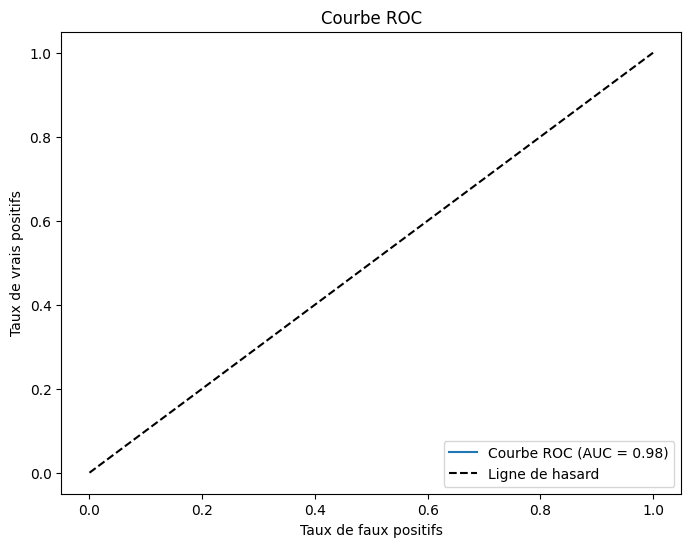

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Prédire les probabilités  
y_proba = model.predict_proba(X_test)[:, 1]

# Calculer le taux de faux positifs (FPR) et le taux de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# Calculer l'AUC
auc = roc_auc_score(y_test, y_proba)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Ligne de hasard')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


In [24]:
from sklearn.model_selection import cross_val_score

lgb_grid_scores = cross_val_score(model_test, X_train, y_train, cv=5, scoring='roc_auc', verbose=0)
print(f'ROC-AUC: {round(lgb_grid_scores.mean(), 2)}')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2547, in _catboost.get_float_feature
  File "_catboost.pyx", line 1226, in _catboost._FloatOrNan
  File "_catboost.pyx", line 1021, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'CHASKA'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3127, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2591, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2549, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="CHASKA": Cannot convert 'b'CHASKA'' to float

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2547, in _catboost.get_float_feature
  File "_catboost.pyx", line 1226, in _catboost._FloatOrNan
  File "_catboost.pyx", line 1021, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'GARDENA'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 2395, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 2275, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs, graph,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 1513, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, graph=graph, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 855, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "/home/flavigny/Documents/DEV_IA/AccordPretEntreprise/.venv/lib/python3.12/site-packages/catboost/core.py", line 1491, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, graph, weight,
  File "_catboost.pyx", line 4339, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4391, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4200, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 3127, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2591, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2549, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=0]="GARDENA": Cannot convert 'b'GARDENA'' to float
